In [10]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd

In [3]:
def psr_to_gaia_nominal(jname, raj, decj, radius):
    """
        looks for Gaia matches to a single pulsar within a specified radius, and returns the table resulting 
        from the Gaia query with the psr name, ra and dec
    """
    
    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    sc = SkyCoord(ra= raj, dec= decj, frame= 'icrs', unit=(u.hourangle, u.deg))
    j = Gaia.cone_search_async(coordinate=sc, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        results.add_column(raj, name='Pulsar RA', index=1)
        results.add_column(decj, name='Pulsar DEC', index=2, )
        return results


In [4]:
def psr_to_gaia(jname, raj, decj,  pmra, pmdec, posepoch, radius):
    """Searches Gaia for possible companion to any given pulsar

    Given input parameters read in from a text file following the guidelines of ATNF parameters, 
    queries Gaia DR2 to find matches (nearby objects from Gaia) based on RA and Dec for each object 
    from the text file to within a certain range, the default being 1 arcmin in both ra and dec.

    Args:
        jname (str): Name of the pulsar being checked for matches 
        raj (str): Right ascension of the pulsar in hh:mm:ss.ss format -- is this actually what it is?
        decj (str): Declination of the pulsar in degrees:mm:ss.ss format -- is this actually what it is?
        pmra (str): Proper motion in ra of the pulsar in string format and mas/yr units
        pmdec (str): proper motion in dec of the pulsar in string format and mas/yr units
        posepoch (str): epoch that the data was taken in string format and mjd units
        height (float): Height of Gaia box search in arcminutes
        width (float): Width of Gaia box search in arcminutes 
        radius (float): Radius of the Gaia cone search in arcminutes
    
    Returns:
        Table: results of the Gaia query in an astropy Table  
    """

    from astropy.time import Time 
    p_ra = raj # comes in as a string of units hh:mm:ss.ss
    p_dec = decj # comes in as a string of units dd:mm:ss.s
    p_pmra = pmra # comes in as a string of units mas/yr
    p_pmdec = pmdec # comes in as a string of units mas/yr
    p_epoch = Time(posepoch, format='mjd').jyear # comes in in units mjd, is immediately converted to jyear tcb

    p_ra_ang = Angle(p_ra + ' hours') # stores the ra in hms as an Angle object
    p_dec_ang = Angle(p_dec + ' degrees') # stores the dec in dms as an Angle object

    p_ra_deg = p_ra_ang.degree * u.deg # stores the ra converted to degrees 
    p_dec_deg = p_dec_ang.degree * u.deg # stores the dec converted to degrees

    # first create variables for the pm units as they come in from atnf, mas/yr
    pmra_masyr = float(p_pmra) * u.mas / u.yr
    pmdec_masyr = float(p_pmdec) * u.mas /u.yr

    # then convert to variable that represent the pms in deg/yr
    pmra_degyr = pmra_masyr.to(u.deg / u.yr)
    pmdec_degyr = pmdec_masyr.to(u.deg / u.yr)

    # to propogate location of pulsar up to gaia time, must calculate epoch difference
    gaia_epoch = Time('2016.0', format='jyear').jyear
    year_diff = (gaia_epoch.tolist() * u.yr) - (p_epoch.tolist() * u.yr) # difference b/w epochs in years

    # get the new ra and dec for the pulsar by updating to gaia epoch 
    p_new_ra = p_ra_deg + (pmra_degyr * year_diff) #   CHANGE BACK TO PMRA_DEGYR WHEN DONE
    p_new_dec = p_dec_deg + (pmdec_degyr * year_diff)#   CHANGE BACK TO PMDEC_DEGYR WHEN DONE

    print(p_new_ra)
    print(p_new_dec)

    # ra_ext_pos = raj + rajerr + (pmra + pmraerr)*year_diff
    # ra_ext_neg = raj - rajerr + (pmra - pmraerr)*year_diff

    # dec_ext_pos = decj + decjerr + (pmdec + pmdecerr)*year_diff
    # dec_ext_neg = decj - decjerr + (pmdec - pmdecerr)*year_diff



    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    coord=SkyCoord(ra=p_new_ra, dec=p_new_dec, unit=(u.degree, u.degree), frame='icrs')
    j = Gaia.cone_search_async(coordinate=coord, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        return results

In [15]:
def get_matches(input_file, radius=1.):
    """Takes a list of pulsars and returns a list of those with potential matches.

    Takes as input a text file (.csv file) with index number, name, ra, dec, proper
    motion ra, proper motion dec and posepoch of a list of pulsars and produces all of the gaia 
    matches of ra and dec to within a certain range.

    Args: 
        input_file (str): Name of the text file (csv) containing each pulsar with the parameters 'index', 'jname', 
            'ra', 'dec', 'pmra', 'pmdec', 'posepoch' row by row for each object.
        output_file (str): Name of the text file which the pulsar-gaia matches will be output to. If desired,
            specify the full path to which the file should be saved, otherwise it will just be saved to the 
            present working directory
        height (:obj:'float', optional): Height of the rectangle Gaia will query in.
        width (:obj:'float', optional): Width of the rectangle Gaia will query in.
        radius (:obj:'float', optional): Radius of the circle Gaia will query in. 


    """
    from astropy.table import Table, vstack

    f = open(input_file, "r")
    results = Table()
    first_time = True
    skipped = 0

    # Loop through file of ATNF data and combine tables of Gaia matches into one supertable
    for line in f:

      # Parse input
      values = line.split(';')

      if values[2] == '*' or values[3] == '*':
        skipped += 1
        continue

      # Add result to supertable
      search_result = psr_to_gaia_nominal(values[1],values[2],values[3],radius)
      if (len(search_result) == 0):
        continue
      if first_time:
        results = search_result
        first_time = False
      else:  
        results = vstack([results, search_result])

    hits = len(results)
    # results.write(output_file, format='csv', overwrite=True)
    return results, hits, skipped

In [16]:
# first step is to run get matches for 10 arcsec
table, hits, skipped = get_matches('nominal_matches.csv', radius= 10.)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [17]:
this_is_the_table = table
hits

33301

In [28]:
psr_pos = SkyCoord(table['Pulsar RA'], table['Pulsar DEC'], frame = 'icrs', unit =(u.hourangle, u.deg))
source_pos = SkyCoord(table['ra'], table['dec'], frame = 'icrs', unit= (u.deg, u.deg))

source_seps = []
first_time = True
for k in range(len(table)):
    if first_time:
        source_seps.insert(0,psr_pos[k].separation(source_pos[k]))
        first_time = False
    else:
        source_seps.append(psr_pos[k].separation(source_pos[k]))

source_seps

[<Angle 0.00088889 deg>,
 <Angle 0.00126013 deg>,
 <Angle 0.00131108 deg>,
 <Angle 0.00236737 deg>,
 <Angle 6.30114495e-05 deg>,
 <Angle 0.00078763 deg>,
 <Angle 0.00090816 deg>,
 <Angle 0.00124207 deg>,
 <Angle 0.00188554 deg>,
 <Angle 0.00195218 deg>,
 <Angle 0.00209481 deg>,
 <Angle 0.00215343 deg>,
 <Angle 0.00216572 deg>,
 <Angle 0.00216142 deg>,
 <Angle 0.00220093 deg>,
 <Angle 0.00223845 deg>,
 <Angle 0.00249211 deg>,
 <Angle 0.00251479 deg>,
 <Angle 0.00263269 deg>,
 <Angle 0.00266018 deg>,
 <Angle 0.00090808 deg>,
 <Angle 0.00092416 deg>,
 <Angle 0.00108168 deg>,
 <Angle 0.00114676 deg>,
 <Angle 0.00119718 deg>,
 <Angle 0.0012899 deg>,
 <Angle 0.00156567 deg>,
 <Angle 0.00159142 deg>,
 <Angle 0.00163275 deg>,
 <Angle 0.00175924 deg>,
 <Angle 0.00182705 deg>,
 <Angle 0.00183886 deg>,
 <Angle 0.0018791 deg>,
 <Angle 0.00223636 deg>,
 <Angle 0.0022391 deg>,
 <Angle 0.00224522 deg>,
 <Angle 0.00237265 deg>,
 <Angle 0.00271378 deg>,
 <Angle 0.00024082 deg>,
 <Angle 0.00067328 deg>,

In [42]:
seps1 = np.linspace(0,10,200)
seps2 = np.linspace(0, 4, 25)

numhits1 = np.zeros(len(seps1)) 
for i in range(len(seps1)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps1[i]:
            num += 1
    numhits1[i] = num

numhits2 = np.zeros(len(seps2)) 
for i in range(len(seps2)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps2[i]:
            num += 1
    numhits2[i] = num

numhits2

array([   0.,   10.,   51.,   94.,  149.,  257.,  349.,  460.,  606.,
        823.,  986., 1198., 1409., 1618., 1830., 2110., 2432., 2714.,
       2969., 3273., 3646., 4080., 4497., 4833., 5314.])

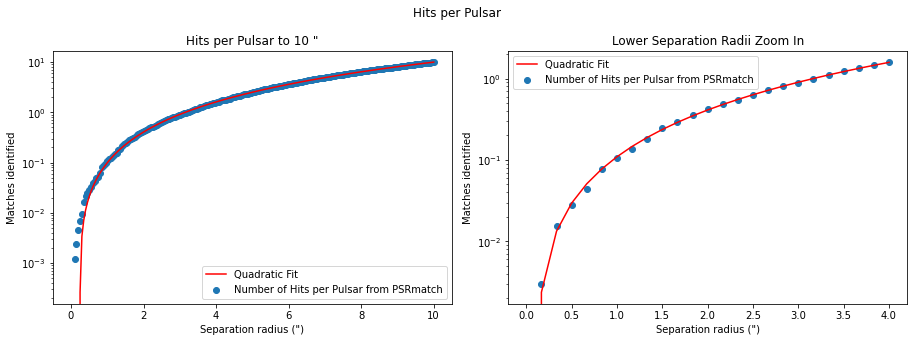

In [43]:
hits_per_pulsar1 = numhits1/3342
hits_per_pulsar2 = numhits2/3342
a1, b1, c1 = np.polyfit(seps1, hits_per_pulsar1, 2)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(12.8, 4.8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_yscale('log')
ax1.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
ax1.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
ax1.set_xlabel('Separation radius (")')
ax1.set_ylabel('Matches identified')
ax1.set_title('Hits per Pulsar to 10 "')
ax1.legend()

#ax1.savefig('/home/annika_deutsch/Binary-Pulsar-Distances/queryradius.pdf')

ax2.set_yscale('log')
ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax2.set_xlabel('Separation radius (")')
ax2.set_ylabel('Matches identified')
ax2.set_title('Lower Separation Radii Zoom In')
ax2.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()